# Parameter Inference from 21 cm power spectra 

## pyPIPS.datasets

In [2]:
import os, pickle
import numpy as np
from py21cmemu import Emulator
emu = Emulator()

from pyPIPS.datasets import Datapoint, Dataset

2023-05-24 19:15:45.350985: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 19:15:50.072766: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-24 19:15:58.760739: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
def get_21cm_ps(params):
    theta, output, output_errors = emu.predict(params)
    return Datapoint(ks=np.arange(60), zs=np.arange(12), P_kz=output["PS"], params=params)

In [4]:
dataset_save_file = "./data/21cm.pkl"
if os.path.exists(dataset_save_file):
    with open(dataset_save_file, "rb") as f:
        dataset = pickle.load(f)
else:
    dataset = Dataset()
    dataset.generate_from_func(get_21cm_ps, 10000, \
                           {'F_STAR10': [0, 1], 'ALPHA_STAR': [0, 1], 'F_ESC10': [0, 1], \
                            'ALPHA_ESC': [0, 1], 'M_TURN': [0, 1], 't_STAR': [0, 1], \
                            'L_X': [0, 1], 'NU_X_THRESH': [0, 1], 'X_RAY_SPEC_INDEX': [0, 1]})
    dataset.save(dataset_save_file)

In [5]:
train, val, test = dataset.split([0.8, 0.1, 0.1])

print(train.P_kzs.shape)

100%|██████████| 1000/1000 [00:00<00:00, 3977.64it/s]

(8000, 60, 12)


## pyPIPS.models

In [6]:
from pyPIPS.models import BayConvPIPS
import tensorflow as tf

model = BayConvPIPS(train)
model.generate()
model.compile()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_flipout_4 (Conv2DFli  (None, 60, 12, 4)        36        
 pout)                                                           
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 6, 4)         0         
 2D)                                                             
                                                                 
 conv2d_flipout_5 (Conv2DFli  (None, 30, 6, 8)         264       
 pout)                                                           
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 15, 3, 8)         0         
 2D)                                                             
                                                                 
 conv2d_flipout_6 (Conv2DFli  (None, 15, 3, 16)       

In [25]:
model.fit(epochs=5, verbose=1, val_dataset=val)

Epoch 1/5
250/250 [==============================] - 3s 10ms/step - loss: 0.3170 - mse: 0.1048 - mae: 0.2465 - val_loss: 0.2654 - val_mse: 0.1069 - val_mae: 0.2476
Epoch 2/5
250/250 [==============================] - 2s 10ms/step - loss: 0.3224 - mse: 0.1071 - mae: 0.2492 - val_loss: 0.3871 - val_mse: 0.1030 - val_mae: 0.2456
Epoch 3/5
250/250 [==============================] - 2s 10ms/step - loss: 0.2587 - mse: 0.1063 - mae: 0.2481 - val_loss: 0.4954 - val_mse: 0.1054 - val_mae: 0.2482
Epoch 4/5
250/250 [==============================] - 3s 11ms/step - loss: 0.2364 - mse: 0.1058 - mae: 0.2480 - val_loss: 0.3051 - val_mse: 0.1012 - val_mae: 0.2427
Epoch 5/5
250/250 [==============================] - 3s 13ms/step - loss: 0.1523 - mse: 0.1051 - mae: 0.2471 - val_loss: 0.1645 - val_mse: 0.1062 - val_mae: 0.2483


In [26]:
model.epochs

[20, 20, 10, 10, 5, 5, 5, 5, 5, 5]

In [27]:
n_pred = 50
predictions = np.empty((n_pred, *val.all_parameters.shape))
for i in range(n_pred):
    predictions[i] = model.predict(val, verbose=0)
predictions_best = np.nanmean(predictions, axis=0)
predictions_std = np.nanstd(predictions, axis=0)

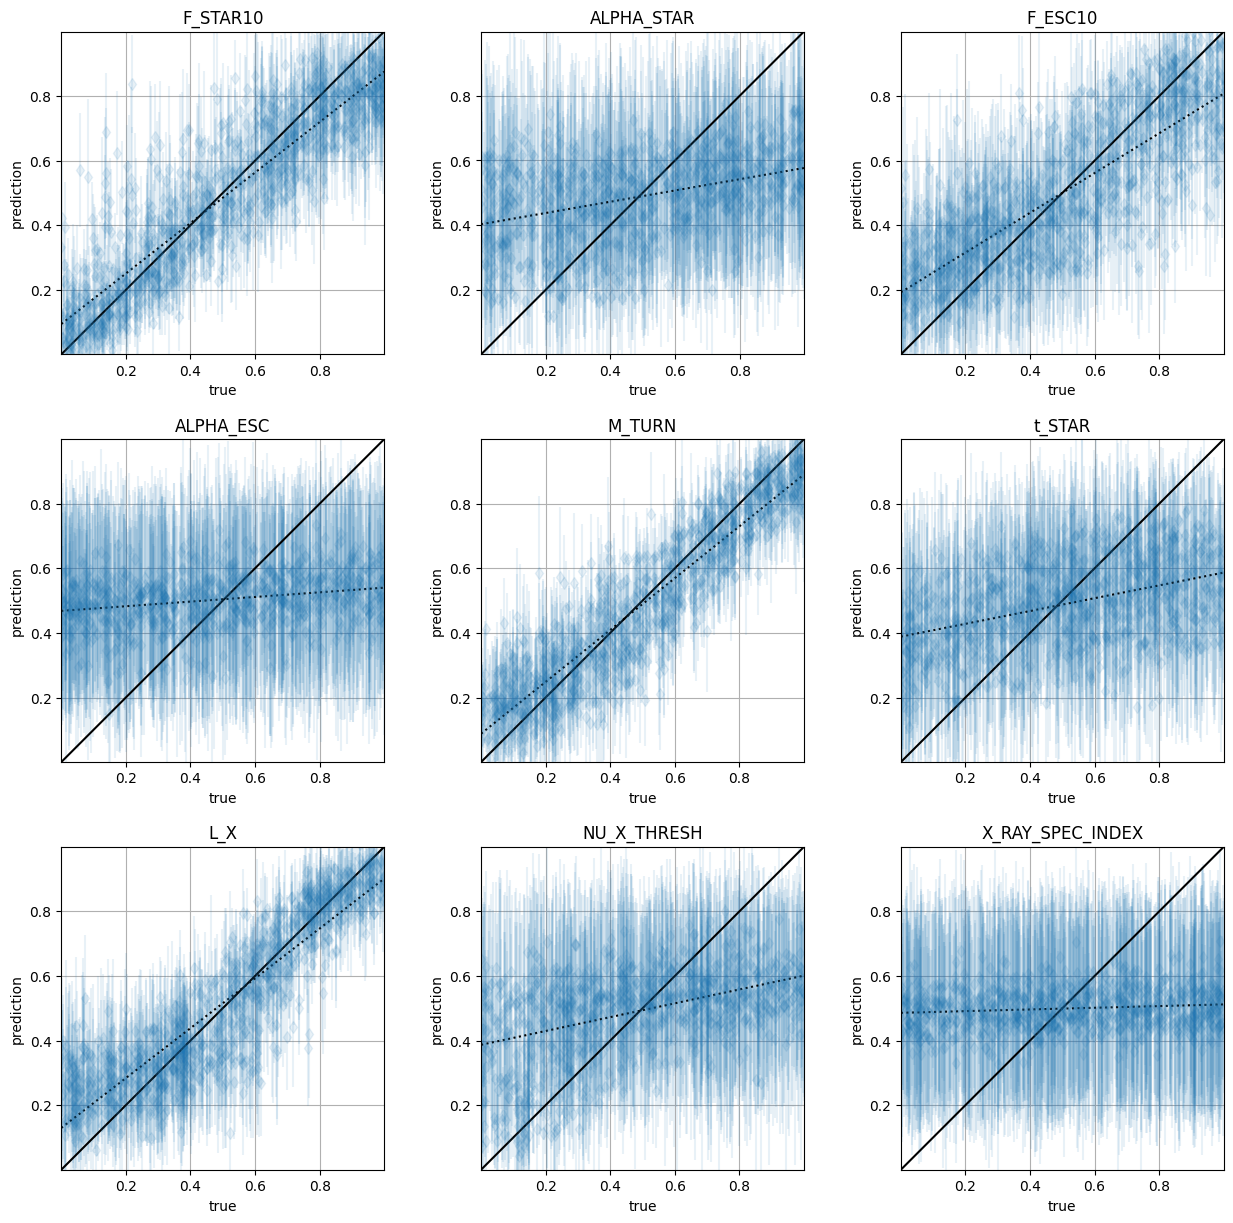

In [28]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
fig.subplots_adjust(wspace=0.3, hspace=0.2)
labels = model.parameters
for ind, (label, ax) in enumerate(zip(labels, axs.ravel())):
    low_lim, upp_lim = np.min(val.all_parameters[:, ind]), np.max(val.all_parameters[:, ind])
    p = np.poly1d(np.polyfit(val.all_parameters[:, ind], predictions_best[:, ind], 1))
    ax.errorbar(val.all_parameters[:, ind], predictions_best[:, ind],  predictions_std[:, ind], marker="d", ls='none', alpha=0.1)
    ax.set_xlabel("true")
    ax.set_ylabel("prediction")
    ax.plot([low_lim, upp_lim], [low_lim, upp_lim], color="black")
    ax.plot([low_lim, upp_lim], [p(low_lim), p(upp_lim)], color="black", ls=":")
    ax.set_xlim([low_lim, upp_lim])
    ax.set_ylim([low_lim, upp_lim])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(label)
    ax.grid()
plt.show()
plt.close()

## pyPIPS.optimize

In [14]:
from pyPIPS import optimize
import importlib
importlib.reload(optimize)

optimizer = optimize.BayConvPIPSOptimizer(train, val)
optimizer.optimize(n_trials=10)

[I 2023-05-24 19:48:11,119] A new study created in memory with name: no-name-d0b80f98-a5c4-43d7-b463-5cc3a5ecd7f1
/global/cfs/cdirs/des/shubh/.conda/envs/pips/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/global/cfs/cdirs/des/shubh/.conda/envs/pips/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


19:48:16, epoch 0: loss: 7.495	mse: 0.359	mae: 0.467	
19:48:42, epoch 15: loss: 3.353	mse: 0.137	mae: 0.293	
19:49:08, epoch 30: loss: 2.026	mse: 0.118	mae: 0.267	
19:49:35, epoch 45: loss: 1.231	mse: 0.111	mae: 0.255	
19:50:02, epoch 60: loss: 0.622	mse: 0.105	mae: 0.247	
19:50:29, epoch 75: loss: 0.202	mse: 0.102	mae: 0.241	
19:50:56, epoch 90: loss: -0.084	mse: 0.100	mae: 0.239	


[I 2023-05-24 19:50:57,641] Trial 0 finished with value: 0.14836588501930237 and parameters: {'n_conv': 3, 'log2(f_conv0)': 4, 'log2(f_conv1)': 5, 'log2(f_conv2)': 2, 'kernel0': 4, 'kernel1': 2, 'kernel2': 5, 'n_dense': 3, 'log2(f_dense0)': 5, 'log2(f_dense1)': 5, 'log2(f_dense2)': 7}. Best is trial 0 with value: 0.14836588501930237.


19:51:01, epoch 0: loss: 25.398	mse: 0.843	mae: 0.709	
19:51:24, epoch 15: loss: 15.963	mse: 0.148	mae: 0.304	
19:51:47, epoch 30: loss: 11.600	mse: 0.130	mae: 0.284	
19:52:09, epoch 45: loss: 7.997	mse: 0.124	mae: 0.274	


In [7]:
model = optimizer.get_best_model()
print(optimizer.get_best_params())

19:39:48, epoch 0: loss: 42.895	mse: 1.373	mae: 0.908	
19:40:10, epoch 15: loss: 28.347	mse: 0.201	mae: 0.354	
19:40:33, epoch 30: loss: 17.423	mse: 0.146	mae: 0.301	
19:40:56, epoch 45: loss: 11.807	mse: 0.135	mae: 0.287	
19:41:18, epoch 60: loss: 8.898	mse: 0.133	mae: 0.282	
19:41:41, epoch 75: loss: 7.134	mse: 0.132	mae: 0.280	
19:42:03, epoch 90: loss: 5.996	mse: 0.130	mae: 0.279	
{}


In [12]:
optimizer.study.best_params['n_dense']

KeyError: 'n_dense'